<div class="list-group" id="list-tab" role="tablist">
<h2 class="list-group-item list-group-item-action active" data-toggle="list" style='background:blue; border:0; color:white' role="tab" aria-controls="home"><center>Quick navigation</center></h2>

* [1 Preface ](#1)
* [2. What is TPU ](#2)
* [3. Setting Up the Environment ](#3)
* [4. Loading Competition Data  ](#4)
* [5. Defining Augmentations ](#5)
* [6. Modelling ](#6)
* [7. Some Pointers to Improve Model's Performance  ](#7)



  


<a id="1"></a>
<h2 style='background:blue; border:0; color:white'><center>1. Preface and About the Kernel</center><h2>


1. This Kernel deals with how to Train Deep Learning Models on TPU.
2. I was learning how to use TPU after discovering about them while doing Flowers Classification using TPU [here](https://www.kaggle.com/c/tpu-getting-started/) 
3. In this kernel I have Also Demonstrated K Fold Cv and Augmentations.
4. I have trained / FineTuned Efficient Net B0.
5. Please Feel free to point out some improvement tips .

In [ ]:
# Import Libraries 
import random, re, math
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import tensorflow as tf, tensorflow.keras.backend as K
from kaggle_datasets import KaggleDatasets
print('Tensorflow version ' + tf.__version__)
from sklearn.model_selection import KFold
from functools import partial
import keras
import pandas as pd, numpy as np
from kaggle_datasets import KaggleDatasets
import tensorflow as tf, re, math
import tensorflow.keras.backend as K
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

## Install Efficient Net 
!pip install -q efficientnet >> /dev/null
import efficientnet.tfkeras as efn



<a id="2"></a>
<h2 style='background:blue; border:0; color:white'><center>2. What is TPU ?</center><h2>


1. A TPU can be thought as of Multiple GPUS clubbed in One Machine .
2. TPU can be used for parallelising Training of Machine Learning Models.
3. A Typical TPU has 8 cores and each core is like a GPU .

To Know more about TPU you can refer the below video .

In [ ]:
import warnings
from IPython.display import YouTubeVideo
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

from IPython.display import HTML
from IPython.display import YouTubeVideo

YouTubeVideo('MXxN4fv01c8', width=800, height=300)

This is how a TPU v3 looks like(Image Credits Wikipedia) .
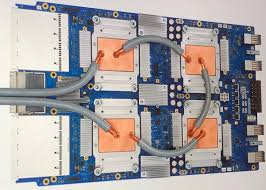

<a id="3"></a>
<h2 style='background:blue; border:0; color:white'><center>3. Setting Up TPU Environment </center><h2>


First We have to define the distribution of strategy for Tensorflow . So that TPU can use this and distribute Jobs accordingly. The below code does exactly the same

In [ ]:
# Detect TPU, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

We can see 8 replicas are return which means that there are 8 cores present Each core is kind of GPU.**NOTE: If Your Notebook Outputs 1 it means you have not Enabled TPU , Enabling TPU is just like Enabling GPU just go to Accelerator Tab and select TPU v3-8**

When using TPU Datasets needs to be stored on Google Cloud Storage bucket , as TPUs are available on Google Cloud Platform . We need to specify the GCS path to load Data .

<a id="4"></a>
<h2 style='background:blue; border:0; color:white'><center>4. Loading Competition Data  </center><h2>


### 4.1 Loading Data from Tfrecords Format 

As Pointed Out Earlier in Some Discussions There was problem in Tf Records Format . So I created A New Dataset in Tfrecords Format , I created a 10 folds Dataset using this [Script](https://www.kaggle.com/dimitreoliveira/cassava-leaf-disease-stratified-tfrecords-256x256) , Stratified based on targets , For verifying Exact Stratification across various Folds , Refer this [Notebook](https://www.kaggle.com/sayedathar11/cassava-leaf-disease-stratified-tfrecords-256x256)

When we are using TPU's , Dataset are often serialized into Tfrecords Format , You can know more about Tfrecords [here](https://www.youtube.com/watch?v=KgjaC9VeOi8&list=PLqFaTIg4myu-1c3ygYzakW8-hNzQG59-5) , 
**In a Nutshell Tfrecords allows distributing various jobs accross cores and helps parallelizing tasks and speeding up Data Loading and Augmentation process**

**Note : That I have created Image of size 256 * 256 if you want to experiment with different Image sizes , just use the above script which was use for 10 Fold Cv Generation and set Size Parameter there to size you want**

In [ ]:
from kaggle_datasets import KaggleDatasets

AUTOTUNE = tf.data.experimental.AUTOTUNE
GCS_PATH_ORI = KaggleDatasets().get_gcs_path('cassava-leaf-disease-classification')
GCS_PATH_NEW = KaggleDatasets().get_gcs_path('tfrecords10foldcv')
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMAGE_SIZE = [256, 256]
CLASSES = ['0', '1', '2', '3', '4']
EPOCHS = 5

A Notable Parameter is Batch_Size , Note that Batch size is set to 16 * Number of Replicas , In Case of our TPU Number of Replicas are 8. So Batch Size becomes 128.

Now we need to Assemble Dataset From Tfrecords so that is in the form that we can feed to our Model ! The Below Code Does the same ! 
PS : **I have hidden the code , you can just read Explanantion of Each Functions Otherwise You Can Just Go through Explanation of Each Functions given below.**

In [ ]:
## Code Credits : https://www.kaggle.com/wuliaokaola/getting-started-tpus-new-tfrecords
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example, labeled):
    tfrecord_format = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.int64)
    } if labeled else {
        "image": tf.io.FixedLenFeature([], tf.string),
        "image_name": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    if labeled:
        label = tf.cast(example['target'], tf.int32)
        return image, label
    idnum = example['image_name']
    return image, idnum

def load_dataset(filenames, labeled=True, ordered=False):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(partial(read_tfrecord, labeled=labeled), num_parallel_calls=AUTOTUNE)
    return dataset


def data_augment(image, label):
    # Thanks to the dataset.prefetch(AUTO) statement in the following function this happens essentially for free on TPU. 
    # Data pipeline code is executed on the "CPU" part of the TPU while the TPU itself is computing gradients.
    image = tf.image.random_flip_left_right(image)
    return image, label

def get_training_dataset(dataset, do_aug = True): # trainingfiles changed to dataset
    #dataset = load_dataset(training_files, labeled=True)  
    dataset = dataset.map(data_augment, num_parallel_calls=AUTOTUNE)  
    if do_aug: dataset = dataset.map(transform ,num_parallel_calls=AUTOTUNE)
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

def get_validation_dataset(validation_files , ordered=False):
    dataset = load_dataset(validation_files, labeled=True, ordered=ordered) 
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset


TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH_ORI + '/test_tfrecords/ld_test*.tfrec')

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

### 4.2 Explanation of Each Functions:
1. `decode_image` :Takes Image which is in Tfrecords format and decodes it into a Tensor , It also normalizes the tensor by scaling values between 0-1 across all 3 Channels . Note that this function is insantiated by read_tfrecord Function which is explained next.

2. `read_tfrecord`: It takes Tfrecord Example and it returns (image , label) pair if we have training data and (image , id) pair , if we have test data.

3. `load_dataset`: It is used Load Training or Test Dataset appropriately . If it loads training data we also do some image Augmentations on our Training Data so that we have more samples of images .

4. `get_training_dataset`: It is used to fetch training dataset by giving appropriate path of Tfrecords in the directory ! Note that this function insantiates `load_dataset` function which uses it to load training dataset.

5. `get_validation_dataset`: In our Case it loads Each Validation Folds appropriately using `load_dataset` utility.

6. `get_test_dataset`: It is used to get test_dataset.

7. `count_data_items` : Usually in each Tfrecords Files we have multiple items for example if we have a Tf record file named `Id_train00-2140.tfrec` , Then this file has 2140 Data items . This code counts all such data items in all tfrecords either train or validation and return their sum.

### 4.3 Conclusion For Data Loaders :

As a concluding point for Data Loaders Functions You can learn more about them in Tfrecords Basic [Kernel](https://www.kaggle.com/ryanholbrook/tfrecords-basics) and getting started kernel [here](https://www.kaggle.com/ryanholbrook/create-your-first-submission) . **I would Emphasize to go over this kernels also so that you can get familiar with workflow and connect dots between these 2 , This will help in future to create DataLoading Pipeline From Scratch**

<a id="5"></a>
<h2 style='background:blue; border:0; color:white'><center>5. Defining Augmentations  </center><h2>


### 5.1 Code for Augmentations

We will use code from Chirs Deotte's [Kernel](https://www.kaggle.com/cdeotte/rotation-augmentation-gpu-tpu-0-96) for Data Augmentation . As Pointed out in this Kernel using `tensorflow.data.Dataset` for Data Augmentations , does Data Augmentation on TPU / GPU which offers Speed up as compared to traditional method of Doing Data Augmentations on a CPU.

We will have following augmentations.
1. Rotate by 20 degrees
2. Shear by 8
3. zoom by some factor 
4. height and width shift by 16

In [ ]:
def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transformmatrix which transforms indicies
        
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    shear = math.pi * shear / 180.
    
    # ROTATION MATRIX
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    rotation_matrix = tf.reshape( tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0),[3,3] )
     # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)
    shear_matrix = tf.reshape( tf.concat([one,s2,zero, zero,c2,zero, zero,zero,one],axis=0),[3,3] )    
    
    # ZOOM MATRIX
    zoom_matrix = tf.reshape( tf.concat([one/height_zoom,zero,zero, zero,one/width_zoom,zero, zero,zero,one],axis=0),[3,3] )
    
    # SHIFT MATRIX
    shift_matrix = tf.reshape( tf.concat([one,zero,height_shift, zero,one,width_shift, zero,zero,one],axis=0),[3,3] )
    
    return K.dot(K.dot(rotation_matrix, shear_matrix), K.dot(zoom_matrix, shift_matrix))

In [ ]:
def transform(image,label):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated, sheared, zoomed, and shifted
    DIM = IMAGE_SIZE[0]
    XDIM = DIM%2 #fix for size 331
    
    rot = 20. * tf.random.normal([1],dtype='float32')
    shr = 8. * tf.random.normal([1],dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1],dtype='float32')/10.
    w_zoom = 1.0 + tf.random.normal([1],dtype='float32')/10.
    h_shift = 16. * tf.random.normal([1],dtype='float32') 
    w_shift = 16. * tf.random.normal([1],dtype='float32') 
  
    # GET TRANSFORMATION MATRIX
    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift) 

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
     # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(m,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image,tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3]),label

### 5.2 Displaying Some Augmentations Example

In [ ]:
print("Displaying Image with Augmentations")
row = 3; col = 4;
foldno = list(np.arange(10))
training_example =  tf.io.gfile.glob(GCS_PATH_NEW + '/Id_train00-2140.tfrec')

all_elements = get_training_dataset(load_dataset(training_example),do_aug=False).unbatch()
one_element = tf.data.Dataset.from_tensors( next(iter(all_elements)) )
augmented_element = one_element.repeat().map(transform).batch(row*col)

for (img,label) in augmented_element:
    plt.figure(figsize=(15,int(15*row/col)))
    for j in range(row*col):
        plt.subplot(row,col,j+1)
        plt.axis('off')
        plt.imshow(img[j,])
    plt.show()
    break

In [ ]:
print("Displaying Image with Augmentations")

row = 3; col = 4;
foldno = list(np.arange(10))
training_example =  tf.io.gfile.glob(GCS_PATH_NEW + '/Id_train01-2140.tfrec')

all_elements = get_training_dataset(load_dataset(training_example),do_aug=False).unbatch()
one_element = tf.data.Dataset.from_tensors( next(iter(all_elements)) )
augmented_element = one_element.repeat().map(transform).batch(row*col)

for (img,label) in augmented_element:
    plt.figure(figsize=(15,int(15*row/col)))
    for j in range(row*col):
        plt.subplot(row,col,j+1)
        plt.axis('off')
        plt.imshow(img[j,])
    plt.show()
    break

In [ ]:
print("Displaying Image with Augmentations")

row = 3; col = 4;
foldno = list(np.arange(10))
training_example =  tf.io.gfile.glob(GCS_PATH_NEW + '/Id_train09-2139.tfrec')

all_elements = get_training_dataset(load_dataset(training_example),do_aug=False).unbatch()
one_element = tf.data.Dataset.from_tensors( next(iter(all_elements)) )
augmented_element = one_element.repeat().map(transform).batch(row*col)

for (img,label) in augmented_element:
    plt.figure(figsize=(15,int(15*row/col)))
    for j in range(row*col):
        plt.subplot(row,col,j+1)
        plt.axis('off')
        plt.imshow(img[j,])
    plt.show()
    break

<a id="6"></a>
<h2 style='background:blue; border:0; color:white'><center>6. Modelling   </center><h2>


### 6.1 Defining Model Architecture 

1. For Modelling we Will Use **EfficientNetB0** , You can learn more about EfficientNet [Here](https://www.youtube.com/watch?v=4U2WO8ObGGU&t=379s) .

2. We will use Transfer Learning to Fine tune  Layers of EfficientNet !

3. Another thing can be using Various Efficient Architectures like B1, B2 .. ,B6 and selecting what suits the problem best.

4. Also Since we have Power of TPU one can Also Train EfficientNet from Scratch !


**Note : Since we are using TPU we need to define our model inside a context manager which is `strategy.scope` , What this context manager does is effectively it tells the TPU how to distribute Training on different Cores**

In [ ]:

def build_model():
    with strategy.scope():       
        #img_adjust_layer = tf.keras.layers.Lambda(tf.keras.applications.efn.EfficientNetB0.preprocess_input, input_shape=[*IMAGE_SIZE, 3])

        base_model = efn.EfficientNetB0(weights='imagenet', include_top=False)
        base_model.trainable = True

        model = tf.keras.Sequential([
            base_model,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(len(CLASSES), activation='softmax')  
        ])
        opt = tf.keras.optimizers.Adam(lr=0.00001)
        model.compile(
        optimizer=opt,
        loss='sparse_categorical_crossentropy',  
        metrics=['sparse_categorical_accuracy'])
        return model
    

### 6.2 Defining Learning Rate Schedule 

The core idea is since we are using Transfer Learning , if we use very large learning rate initially , That will cause drastic updates in the weights of pretrained Efficient Net ! We want to utilize our pretrained model hence it is better to start with smaller Learning Rate like 1e-5 and gradually move towards 1e-3 , Refer This [video](https://www.youtube.com/watch?v=DEuvGh4ZwaY&t=2706s) for more on this !

In [ ]:
# Code Credits : https://www.kaggle.com/cdeotte/how-to-compete-with-gpus-workshop

LR_START = 0.00001
LR_MAX = 0.00005 * strategy.num_replicas_in_sync
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

rng = [i for i in range(25 if EPOCHS<25 else EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))


### 6.3 Training and Validating Model :

For the above model an epoch takes **less than 30s** and within **5 Epochs**  we are able to reach an accuracy of **~84 % on Validation Data** ! This is absolutely good as we train the entire model from scratch! Just unhide the Output Cell of the Model if you want to see the results for each Folds .

In [ ]:
FOLDS =  10
foldno = np.arange(10)
models = []
histories = []
for fold in foldno:
    training_files = tf.io.gfile.glob([GCS_PATH_NEW + '/Id_train%.2i*.tfrec'%x for x in foldno if x != fold])
    NUM_TRAINING_IMAGES = count_data_items(training_files)

    validation_files = tf.io.gfile.glob([GCS_PATH_NEW + '/Id_train%.2i*.tfrec'%x for x in foldno if x == fold])
    train_dataset = load_dataset(training_files)                              #get_training_dataset(training_files)
    valid_dataset = get_validation_dataset(validation_files)                              #get_validation_dataset(validation_files)
    NUM_VALIDATION_IMAGES = count_data_items(validation_files)
    STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
    VALID_STEPS = NUM_VALIDATION_IMAGES // BATCH_SIZE
    model = build_model()
    history = model.fit(get_training_dataset(train_dataset), 
                    steps_per_epoch=STEPS_PER_EPOCH, 
                    epochs=EPOCHS,
                    validation_data=valid_dataset,
                    validation_steps=VALID_STEPS , 
                    callbacks = [lr_callback])
    
    models.append(model)
    path  = f'Cassava_Model_EFFNETB0:_Fold:{fold}.hdf5'
    model.save(path)
    histories.append(history)
    
    print(" ")


### 6.4 Conclusions:

1. With just 5 Epochs we reach pretty good accuracy of 84-85 % .
2. Using TPU Speeds up things like crazy for Example Training Such a Model without FineTuning the EfficientNet layer could take minutes for each epochs , **Using TPU we completed Each Epochs within 30 seconds**.
3. Use of TPUs Make K-Fold Cross Validation very much feasible however we must prepare Data in Tfrecords Format before Hand .
4. Augmentations become much more faster while using TPUs.

<a id="7"></a>
<h2 style='background:blue; border:0; color:white'><center>7.Some Pointers on Improving Models Performance</center><h2>


Even though EfficientNet B0 used here performs quite well , it can be improved tremendously well by following some of the listed tips.


1. Trying out other variations of Efficient Net like B1 , B2 , .. B6.
2. Trying out some more technqiues of Fine Tuning Like Feature Extraction , Freezing Initial Layers and Tuning Last Few Layers.
3. Adding Dropouts and Regularization like L1 or L2 Regularization.
4. Trying out different Learning Rate Schedules and adding some more callbacks like Early Stopping.
5. Experimenting with some more augmentations other than those define here ! 
6. Ensembling the predictions of various EfficientNet models and Also various CNNs **[This should be done at the end of competition after trying out single best models]**

### Teaming UP :
**If You have Good Experience in Computer Vision and are looking for Team Member to Ace this competition I am available 😊 , I would be Glad to Learn From You and also teach you some of the techniques I have learnt**